In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import floor
# Benford's law can be calculated on any base besides 10, change it here!
base = 7

In [2]:
def first_digit(num):
    n = np.math.log(num, base)
    return floor(pow(base, n - floor(n)))

In [3]:
import requests
url = 'https://enr.electionsfl.org/DAD/2779/Precincts/35849/0/865/'

In [4]:
headers = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
           "(KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}
r = requests.get(url, headers=headers)

In [5]:
from bs4 import BeautifulSoup as bs

In [6]:
bs_data = bs(r.text, 'html.parser')

In [7]:
precincts_tables = bs_data.findAll('table', {'class': 'DetailResults'})

In [8]:

dataset = pd.DataFrame()

index = 1

# for each precinct
for result in precincts_tables:

    # each row is a candidate
    all_candidate_cols = result.find_all('tr')
    
    new_row = {}
        
    # parse the columns
    for i in range(1, len(all_candidate_cols)):
        candidate_cols = all_candidate_cols[i]

        # parse the columns, one is the name the other is the total votes
        col_values = candidate_cols.find_all('td')

        # each row is a candidate starting from 1

        remove_tags = ['REP', 'DEM', 'LPF', 'REF', 'PSL', 'GRE', 'CPF']

        # first column is candidate name, remove superfluous white space
        candidate = col_values[0].text
        for tag in remove_tags:
            candidate = candidate.replace('({})'.format(tag), '')
        candidate = candidate.strip()

        # get the vote count (second to last column)        
        votes = int(col_values[-2].text.replace(',', ''))
        new_row[candidate] = votes


    dataset = dataset.append(pd.Series(new_row, name=index))

    index += 1
    

In [9]:
unstacked_data = dataset.unstack().reset_index().rename(
columns={0: 'count', 'level_0': 'candidate', 'level_1': 'index'}
)

In [10]:
unstacked_data.head()

,candidate,index,count
0,Don Blankenship,1,0.0
1,Don Blankenship,2,0.0
2,Don Blankenship,3,0.0
3,Don Blankenship,4,0.0
4,Don Blankenship,5,0.0


Text(0.5, 0.98, 'Miami-Dade')

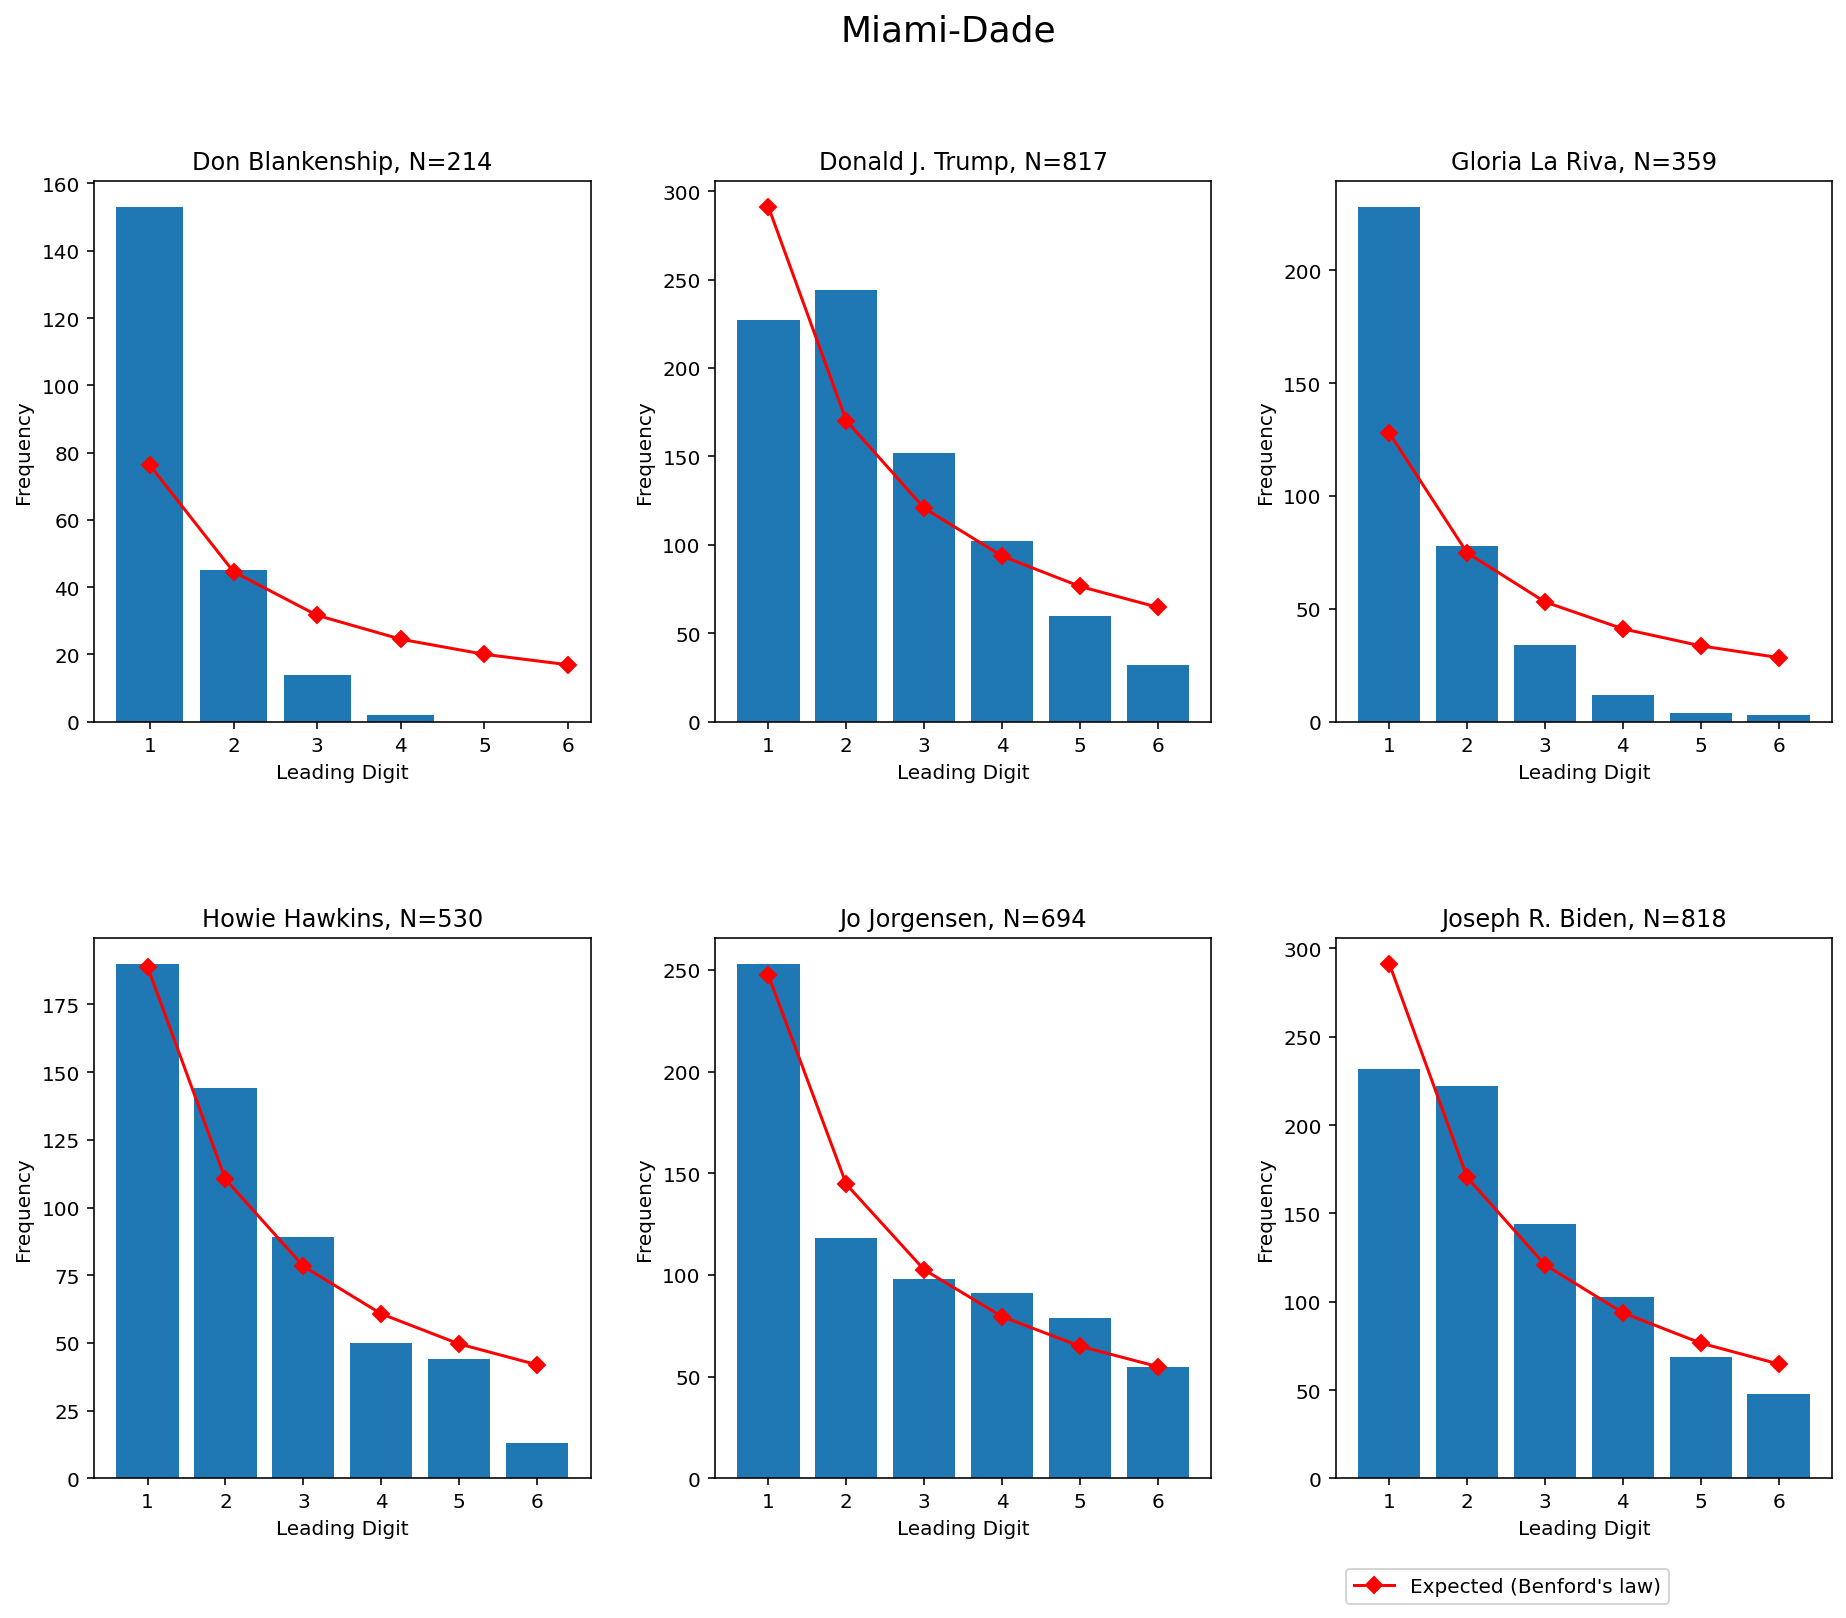

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
fig.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.subplots_adjust(hspace=0.4, wspace=0.25)

axs = np.array(axs).flatten()
candidates = unstacked_data.candidate.unique()

digit = np.arange(1, base)

def first_digit(num):
    n = np.math.log(num, base)
    return floor(pow(base, n - floor(n)))


for i in range(len(axs)):
    candidate = candidates[i]
    
    N = len(dataset[dataset[candidate] > 0])

    # expected distribution, from benford's law, normalize by non-zero counts
    expected = np.log(1 + 1/digit) / np.log(base) * N
    
    ax = axs[i]
    cur_data = unstacked_data
    cur_data = cur_data.groupby(['candidate', 'index']).sum()
    data = cur_data.loc[candidate]['count'].astype(int)
    data = data[data > 0]
    digits = data.apply(first_digit)
    
    v = digits.value_counts()
    
    ax.bar(v.index, v.values)
    ax.set_xticks(range(1, base))

    ax.set_title("%s" % (candidate))
    ax.plot(digit, expected, marker='D', color='red', label='Expected (Benford\'s law)')
    
    ax.set_title("%s, N=%d" % (candidate, N))
    ax.set_xlabel("Leading Digit")
    ax.set_ylabel("Frequency")

plt.legend(loc=3, bbox_to_anchor=(0.0, -0.25))    
plt.suptitle("Miami-Dade", fontsize=18)
    